<a href="https://colab.research.google.com/github/jiin-son/nba/blob/main/NBA_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.3f}'.format

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.metrics import precision_score, recall_score, roc_auc_score

In [ ]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving prep_df.csv to prep_df.csv


In [ ]:
df = pd.read_csv('prep_df.csv')

In [ ]:
import random
import hashlib

def md5_hash(input_string):
  """Generates an MD5 hash from a given string.
  Args:
    input_string: The string to hash.
  Returns:
    The MD5 hash as a hexadecimal string.
  """
  md5_hasher = hashlib.md5()
  md5_hasher.update(input_string.encode('utf-8'))
  return md5_hasher.hexdigest()

# Example usage
input_string = "NBA"
hashed_value = md5_hash(input_string)
print(f"The MD5 hash of '{input_string}' is: {hashed_value}")

# Convert the hexadecimal hash to an integer
try:
    number = int(hashed_value, 16)
    print(f"The integer representation of the hash is: {number}")
except ValueError:
    print("Invalid hexadecimal string")

# Set the seed value
random.seed(number)

print(f"Initial seed number: {number}")

# Generate a list of 10 random numbers
random.seed(number)
a = 0
b = 2**31-1
random_numbers = [random.randint(a, b) for _ in range(10)]

# Print the list
print("Seed", random_numbers)

The MD5 hash of 'NBA' is: 52b6d6fc82db6aef110362f4755a1fe8
The integer representation of the hash is: 109946054124266886270703940407869972456
Initial seed number: 109946054124266886270703940407869972456
Seed [1578879816, 1978497697, 1190903919, 1878057853, 1288653849, 873208946, 343223680, 1954458820, 1609495891, 882467736]


In [ ]:
df

,HOME,OVERTIME,REST_DAYS,FG_PCT,FT_PCT,REB,AST,STL,BLK,TO,...,TEAM_MIA,TEAM_UTA,TEAM_LAL,TEAM_POR,TEAM_MIN,TEAM_NYK,TEAM_BKN,TEAM_ATL,TEAM_NOP,W
0,0.0,0.0,2.0,0.421,1.000,3.0,3.0,1.0,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
1,0.0,0.0,2.0,0.412,0.833,10.0,1.0,2.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
2,0.0,0.0,2.0,0.500,1.000,9.0,1.0,1.0,0.0,4.0,...,0,0,0,0,0,0,0,0,0,0.0
3,0.0,0.0,2.0,0.308,0.500,4.0,4.0,1.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0.0
4,0.0,0.0,2.0,0.167,0.000,8.0,6.0,0.0,0.0,2.0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9630,1.0,0.0,0.0,0.100,0.000,4.0,4.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1.0
9631,1.0,0.0,0.0,0.400,0.000,5.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
9632,1.0,0.0,0.0,0.167,0.000,7.0,2.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0
9633,1.0,0.0,0.0,0.000,0.000,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.0


In [ ]:
seed1 = random_numbers[0]

In [ ]:
X = df.drop(['W'], axis = 1)
y = df['W']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed1)

In [ ]:
# Define objective function
def objective(trial):
    # Suggest values for hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.9)
    n_estimators = trial.suggest_int("n_estimators", 10, 200, log=True)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)
    min_impurity_decrease= trial.suggest_float("min_impurity_decrease", 0.1, 0.9)


    # Create and fit random forest model
    model = GradientBoostingClassifier(
    learning_rate = learning_rate,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    min_impurity_decrease = min_impurity_decrease,
    random_state=seed1,
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = [1 if y > 0.5 else 0 for y in y_pred]
    accuracy = accuracy_score(y_test,y_pred)

    return accuracy

In [ ]:
# Create study object
study = optuna.create_study(direction="maximize")

# Run optimization process
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-01-24 01:44:53,970] A new study created in memory with name: no-name-337ce16e-73d8-405e-82f7-528701b46e65


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-01-24 01:44:55,230] Trial 0 finished with value: 0.6829268292682927 and parameters: {'learning_rate': 0.5003268204884084, 'n_estimators': 45, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.533313929733857}. Best is trial 0 with value: 0.6829268292682927.
[I 2025-01-24 01:44:56,243] Trial 1 finished with value: 0.6569797612869746 and parameters: {'learning_rate': 0.5372861085876991, 'n_estimators': 26, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.5542065762229831}. Best is trial 0 with value: 0.6829268292682927.
[I 2025-01-24 01:44:59,613] Trial 2 finished with value: 0.6673585884795018 and parameters: {'learning_rate': 0.31537866959181493, 'n_estimators': 68, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 10, 'min_impurity_decrease': 0.4007070011674474}. Best is trial 0 with value: 0.6829268292682927.
[I 2025-01-24 01:45:01,586] Trial 3 finished with value: 0.7026466009340945 

In [ ]:
# Print best trial and best hyperparameters
print("Best trial:", study.best_trial)
print("Best hyperparameters:", study.best_params)

Best trial: FrozenTrial(number=12, state=1, values=[0.7093928386092372], datetime_start=datetime.datetime(2025, 1, 24, 1, 45, 18, 128613), datetime_complete=datetime.datetime(2025, 1, 24, 1, 45, 20, 799050), params={'learning_rate': 0.1180641355266149, 'n_estimators': 33, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 7, 'min_impurity_decrease': 0.7327810806875493}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.9, log=False, low=0.1, step=None), 'n_estimators': IntDistribution(high=200, log=True, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_split': IntDistribution(high=10, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=2, step=1), 'min_impurity_decrease': FloatDistribution(high=0.9, log=False, low=0.1, step=None)}, trial_id=12, value=None)
Best hyperparameters: {'learning_rate': 0.1180641355266149, 'n_estimators': 33, 

In [ ]:
xg_model = GradientBoostingClassifier(
    learning_rate = 0.1180641355266149,
    n_estimators=33,
    max_depth=7,
    min_samples_split=8,
    min_samples_leaf=7,
    min_impurity_decrease = 0.7327810806875493,
    random_state=seed1)
xg_model.fit(X_train,y_train)
y_pred = xg_model.predict(X_test)
y_pred = [1 if y > 0.5 else 0 for y in y_pred]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(f"Specificity: {precision_score(y_test, y_pred):.3f}")
print(f"Sensitivity: {recall_score(y_test, y_pred):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.3f}")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.709
F1 Score: 0.709
Specificity: 0.697
Sensitivity: 0.743
ROC AUC: 0.709
[[650 312]
 [248 717]]


In [ ]:
!pip install shap
import shap

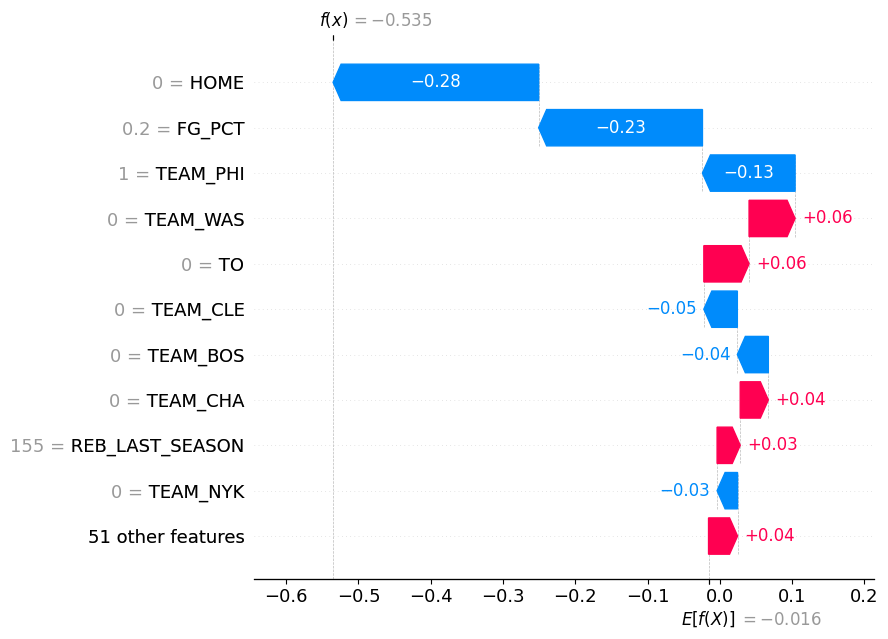

In [ ]:
# (4) Train 3 seeds and pick up 1 representative seed result to explain feature to target relationships using shap.
explainer = shap.Explainer(xg_model, X_train)
shap_values = explainer(X_test, check_additivity = False)
# which of the variables are important to the target = bare_nuclei
shap.plots.waterfall(shap_values[0], max_display = 11)

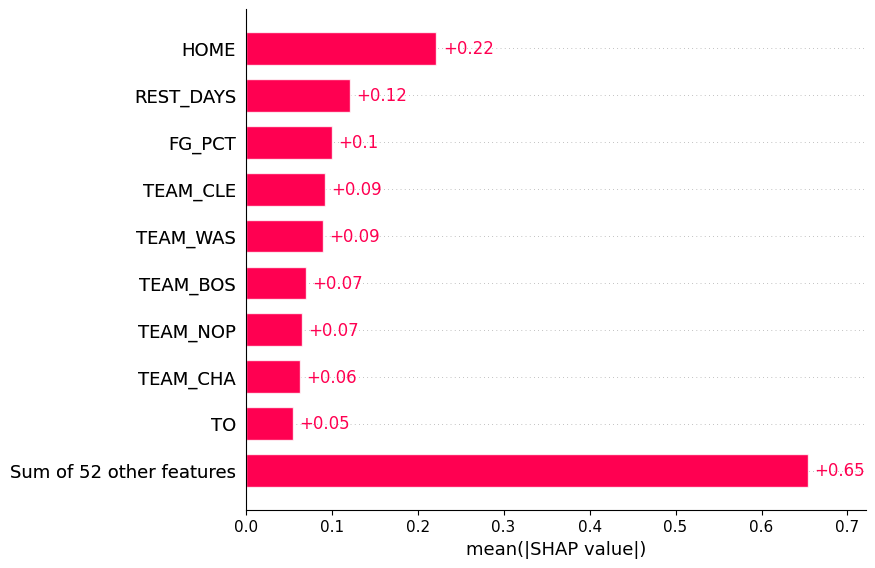

In [ ]:
shap.plots.bar(shap_values)

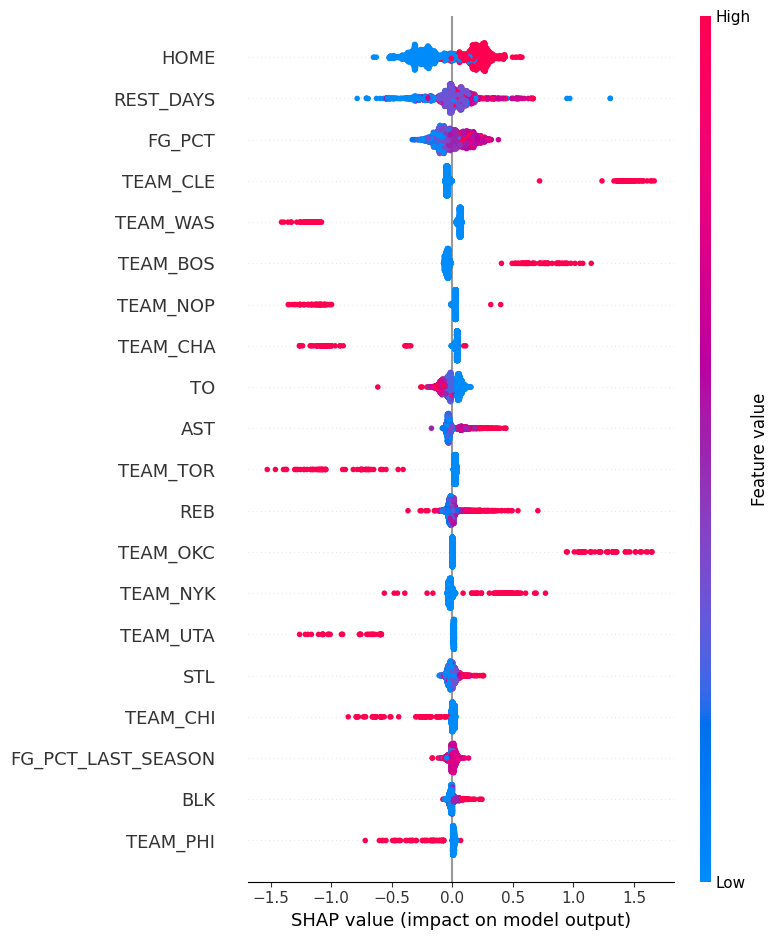

In [ ]:
shap.summary_plot(shap_values)